## ISS Predictor

In [1]:
import numpy as np

from htm.bindings.sdr import SDR
from htm.bindings.encoders import ScalarEncoder, ScalarEncoderParameters
from htm.algorithms import SpatialPooler as SP
from htm.algorithms import TemporalMemory as TM
from htm.bindings.algorithms import Predictor

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import json, urllib.request, time

In [2]:
scalarEncoderParams = ScalarEncoderParameters()
scalarEncoderParams.minimum = -180
scalarEncoderParams.maximum = 180
scalarEncoderParams.activeBits = 4
scalarEncoderParams.size = 128
scalarEncoderParams.clipInput  = True

enc = ScalarEncoder(scalarEncoderParams)

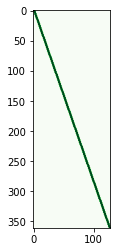

In [3]:
n_samples = int(enc.parameters.maximum - enc.parameters.minimum + 1)

sdrs = []
for i in np.linspace(enc.parameters.minimum, enc.parameters.maximum, n_samples):
    sdrs.append( enc.encode( i ).dense )

#clear_output(wait = True)
#plt.cla
plt.imshow(np.array(sdrs), cmap = "Greens")
plt.show()

In [4]:
inputSDR  = SDR( dimensions = (128 ) )
activeSDR = SDR( dimensions = (576) )
sp = SP(inputDimensions  = inputSDR.dimensions,
        columnDimensions = activeSDR.dimensions,
        localAreaDensity = 0.02,
        globalInhibition = True,
        seed             = 1,
        synPermActiveInc   = 0.01,
        synPermInactiveDec = 0.008)
print(sp)

Spatial Pooler Connections:
    Inputs (128) ~> Outputs (576) via Segments (576)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 17 / 17 / 17
    Connected Synapses on Segment Min/Mean/Max 3 / 8.3941 / 15
    Synapses Dead (0%) Saturated (0%)
    Synapses pruned (0%) Segments pruned (0%)



In [5]:
tm = TM(
    columnDimensions = (576,),
    cellsPerColumn=8,
    initialPermanence=0.5,
    connectedPermanence=0.5,
    minThreshold=8,
    maxNewSynapseCount=20,
    permanenceIncrement=0.1,
    permanenceDecrement=0.0,
    activationThreshold=8,
)
print(tm)

Temporal Memory Connections:
    Inputs (0) ~> Outputs (4608) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)



In [6]:
predictor = Predictor( steps=[1,2,3,4,5])
resolution = 0.01
minimum = -180

In [9]:
seq =[]
predictions = {1: [], 2: [], 3: [], 4: [], 5: []}
for i in range(20):
    url = "http://api.open-notify.org/iss-now.json"
    response = urllib.request.urlopen(url)
    result = json.loads(response.read())

    location =result["iss_position"]

    lon = float(location["longitude"])
    lat = float(location["latitude"])

    seq.append(lon)
    print(lon)
    
    inputSDR = enc.encode(seq[i])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=True)
    
    predictor.learn(i, tm.getActiveCells(), int((seq[i] - minimum) / resolution))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2):
        if pdf[n]:
            predictions[n].append( round(np.argmax( pdf[n] ) * resolution + minimum, 2) )
        else:
            predictions[n].append(float(0))
    #print(predictions )
    
    seq.append(lat)
    print(lat)
    
    inputSDR = enc.encode(seq[i+1])
    sp.compute(inputSDR, True, activeSDR)

    tm.compute( activeSDR, learn=True)
    
    predictor.learn(i, tm.getActiveCells(), int((seq[i+1] - minimum) / resolution))

    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,2):
        if pdf[n]:
            predictions[n].append( round(np.argmax( pdf[n] ) * resolution + minimum, 2) )
        else:
            predictions[n].append(float(0))
            
    print(predictions)
    
    i=+1
    
    time.sleep(5)

163.0187
51.537
{1: [0.0, 0.0], 2: [0.0, 0.0], 3: [], 4: [], 5: []}
163.5177
51.5162
{1: [0.0, 0.0, -180.0, 163.51], 2: [0.0, 0.0, 0.0, 0.0], 3: [], 4: [], 5: []}
164.1656
51.4857
{1: [0.0, 0.0, -180.0, 163.51, 163.51, 51.51], 2: [0.0, 0.0, 0.0, 0.0, 163.51, -180.0], 3: [], 4: [], 5: []}
164.8126
51.4514
{1: [0.0, 0.0, -180.0, 163.51, 163.51, 51.51, 51.51, 164.16], 2: [0.0, 0.0, 0.0, 0.0, 163.51, -180.0, 51.51, 51.51], 3: [], 4: [], 5: []}
165.4584
51.4132
{1: [0.0, 0.0, -180.0, 163.51, 163.51, 51.51, 51.51, 164.16, 163.51, 51.51], 2: [0.0, 0.0, 0.0, 0.0, 163.51, -180.0, 51.51, 51.51, 51.51, 164.16], 3: [], 4: [], 5: []}
166.0536
51.3745
{1: [0.0, 0.0, -180.0, 163.51, 163.51, 51.51, 51.51, 164.16, 163.51, 51.51, 164.16, 164.16], 2: [0.0, 0.0, 0.0, 0.0, 163.51, -180.0, 51.51, 51.51, 51.51, 164.16, 164.16, 164.16], 3: [], 4: [], 5: []}
166.7465
51.3252
{1: [0.0, 0.0, -180.0, 163.51, 163.51, 51.51, 51.51, 164.16, 163.51, 51.51, 164.16, 164.16, 164.81, 51.51], 2: [0.0, 0.0, 0.0, 0.0, 163.5